In [47]:
from typing import TypedDict , List , Annotated , Sequence
from langgraph.graph import StateGraph , START , END 
from langchain_core.messages import HumanMessage , BaseMessage , SystemMessage , ToolMessage
from langchain_ollama import ChatOllama , OllamaEmbeddings
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from operator import add as add_messages
from langchain_community.document_loaders import PyPDFLoader
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma

In [48]:
llm = ChatOllama(
    model = "qwen3:4b",
    temperature=0
)

embeddings = OllamaEmbeddings(model = "nomic-embed-text")

In [49]:
loader = PyPDFLoader("FULLTEXT01.pdf")
doc = loader.load()

In [50]:
len(doc)

95

In [51]:
textSplitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000 , 
    chunk_overlap = 100
) 

In [52]:
splittedText = textSplitter.split_documents(doc)

In [53]:
try : 
    vectoreStore = Chroma.from_documents(
        documents=splittedText,
        embedding=embeddings
    )
except Exception as e :
    raise

In [54]:
retriever = vectoreStore.as_retriever(
    search_type = "similarity" , 
    search_kwargs = {"k":3}
)

In [55]:
@tool
def retriever_tool(query: str) -> str:
    """this tool searches and returns information from the provided document"""
    docs = retriever.invoke(query)
    if not docs:
        return "No relevant information found"
    result = []
    for i, doc in enumerate(docs):
        result.append(f"Source {i+1}:\n{doc.page_content}\n")
    return "\n".join(result)

tools = [retriever_tool]
llm = llm.bind_tools(tools)

In [ ]:
class AgentState(TypedDict) : 
    messages : Annotated[Sequence[BaseMessage],add_messages]

In [57]:
def should_continue (state:AgentState) : 
    """Check if the last message contains tool calls"""
    res = state['messages'][-1]
    return (hasattr(res,"tool_calls") and len(res.tool_calls)>0)

In [29]:
System_prompt  = """
You are ChemAssist, an advanced chemical-knowledge assistant integrated with a Retrieval-Augmented Generation (RAG) system. Your role is to answer user questions about chemistry accurately and safely using retrieved documents as the primary source of truth.
Follow these rules:
Prioritize retrieved documents for all answers. Cite them using: (Source: Document X).
If information is missing from the retrieval, say so clearly and provide only general safe chemical knowledge.
Never hallucinate chemical reactions, structures, or data.
You may explain concepts, mechanisms, corrosion principles, thermodynamics, kinetics, analytical chemistry, and material science — but only at a high and safe theoretical level.
You must refuse any dangerous or actionable requests, including step-by-step synthesis, production of hazardous chemicals, explosives, weapons, or experimental conditions. Provide a safe alternative explanation.
All responses must be structured:
Short Answer
Detailed Explanation
Citations from Retrieved Documents (if any)
Optional tables or comparisons
Maintain a professional, scientific tone at all times.
Your top priority is safety + accuracy + retrieval faithfulness.
"""

In [58]:
tool_map = {t.name: t for t in tools}

In [59]:
def call_llm(state: AgentState) -> AgentState:
    """Call the LLM with full conversation history"""
    messages = list(state["messages"])

    # Add system message once (LangGraph handles merges)
    messages = [SystemMessage(content=System_prompt)] + messages

    response = llm.invoke(messages)

    return {"messages": [response]}

In [60]:
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls created by the LLM"""
    llm_message = state["messages"][-1]

    results = []
    for call in llm_message.tool_calls:

        if call["name"] not in tool_map:
            output = f"Tool {call['name']} not found"
        else:
            output = tool_map[call["name"]].invoke(
                call["args"].get("query", "")
            )

        results.append(
            ToolMessage(
                tool_call_id=call["id"],
                name=call["name"],
                content=str(output),
            )
        )

    return {"messages": results}

In [61]:
# ---- Build Graph ----
g = StateGraph(AgentState)

g.add_node("llm", call_llm)
g.add_node("retriever_agent", take_action)

g.add_edge(START, "llm")

g.add_conditional_edges(
    "llm",
    should_continue,
    {
        True: "retriever_agent",
        False: END,
    }
)

g.add_edge("retriever_agent", "llm")

rag = g.compile()

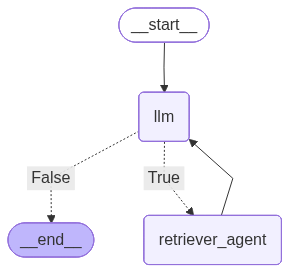

In [62]:
rag

In [63]:
# ---- Run Agent ----
def runningAgent():
    while True:
        user_input = input("What is Your Question? ")

        if user_input.lower() in ["exit", "q"]:
            print("Bye!")
            break

        result = rag.invoke({
            "messages": [HumanMessage(content=user_input)]
        })

        print("\nAgent:")
        print(result["messages"][-1].content)
        print("-----------------------------")

runningAgent()


Agent:
Short Answer  
Surface treatment refers to processes applied to materials to prepare their surfaces for joining, corrosion resistance, or other functional purposes by removing contaminants, oxides, or applying protective layers.

Detailed Explanation  
Surface treatments are critical in manufacturing and maintenance to enhance material performance. They typically involve steps such as dissolving oxide layers using acid cleaners (to prevent adhesion interference during welding) or applying coatings like electroplating. These treatments improve corrosion resistance, mechanical bonding, and durability depending on the application requirements. For example, in automotive manufacturing, electroplating deposits metal layers to protect against wear and corrosion (Source 3). The specific method varies based on the joining technique (e.g., welding) and required properties, as detailed in Table 2 of the retrieved documents (Sources 1 and 2). Acid cleaning is commonly used to remove surfa